In [1]:
from Phase_4_functions import roll_mean_std
from Phase_4_functions import decompose
from Phase_4_functions import DickeyFullerTest
from Phase_4_functions import naive_model
from Phase_4_functions import sarimax_search
from Phase_4_functions import fbprophet_func
from Phase_4_functions import LSTM_func
from Phase_4_functions import LSTM_val

import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from fbprophet import Prophet as proph
import pmdarima as pm

import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('data/new_zillow_data.csv')

In [3]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 
                                  'Metro', 'CountyName', 'RegionType', 'StateName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [4]:
melted = melt_data(df)
melted['time'] = pd.to_datetime(melted['time'])
melted.set_index('time', inplace=True)

## Zip Code 28546 (Jacksonville, NC)

### Plot the Rolling Mean and Rolling Std.

In [5]:
Jacksonville = melted[melted.RegionName == 28546]

In [6]:
Jacksonville

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,RegionType,StateName,value
time,,,,,,,,,,
2001-07-31,28546,70022,734,Jacksonville,NC,Jacksonville,Onslow County,Zip,NC,103652.0
2001-08-31,28546,70022,734,Jacksonville,NC,Jacksonville,Onslow County,Zip,NC,102163.0
2001-09-30,28546,70022,734,Jacksonville,NC,Jacksonville,Onslow County,Zip,NC,101544.0
2001-10-31,28546,70022,734,Jacksonville,NC,Jacksonville,Onslow County,Zip,NC,99843.0
2001-11-30,28546,70022,734,Jacksonville,NC,Jacksonville,Onslow County,Zip,NC,98744.0
...,...,...,...,...,...,...,...,...,...,...
2021-03-31,28546,70022,734,Jacksonville,NC,Jacksonville,Onslow County,Zip,NC,169281.0
2021-04-30,28546,70022,734,Jacksonville,NC,Jacksonville,Onslow County,Zip,NC,171288.0
2021-05-31,28546,70022,734,Jacksonville,NC,Jacksonville,Onslow County,Zip,NC,173431.0


In [7]:
Jacksonville = Jacksonville.resample('MS').mean()
Jacksonville = Jacksonville.drop(['RegionName', 'RegionID', 'SizeRank'], axis=1)

In [8]:
Jacksonville

,value
time,
2001-07-01,103652.0
2001-08-01,102163.0
2001-09-01,101544.0
2001-10-01,99843.0
2001-11-01,98744.0
...,...
2021-03-01,169281.0
2021-04-01,171288.0
2021-05-01,173431.0


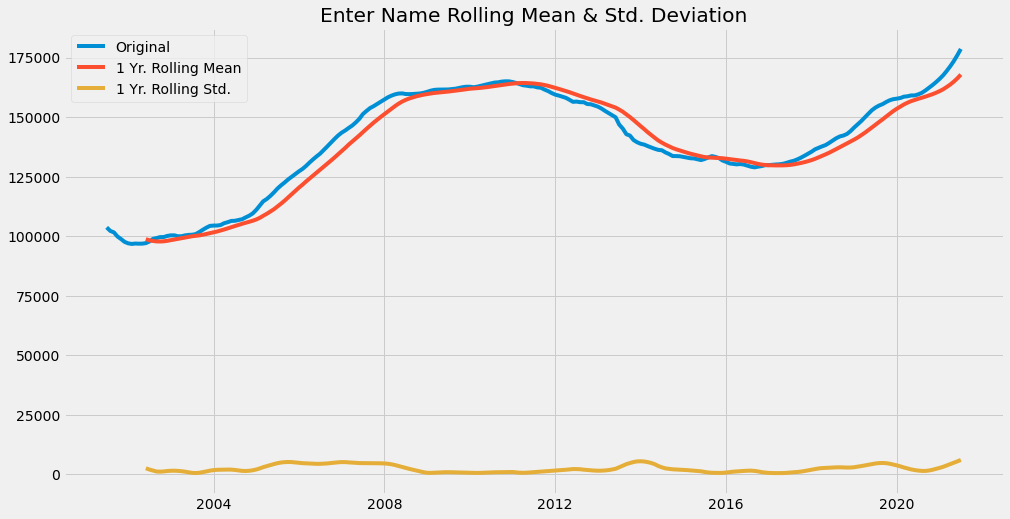

In [9]:
roll_mean_std(Jacksonville)

### Seasonal Decompose

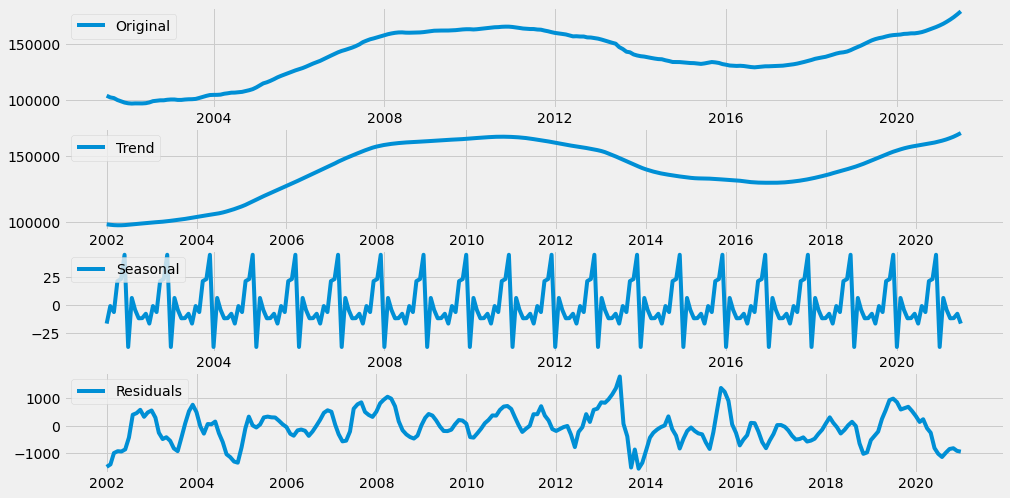

In [10]:
decompose(Jacksonville)

### Differencing and DickeyFuller Test

In [11]:
DickeyFullerTest(Jacksonville)

Test Statistic                  -1.162310
p-value                          0.689595
# Lags Used                     15.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64

Test Statistic                  -0.747488
p-value                          0.834063
# Lags Used                     15.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64

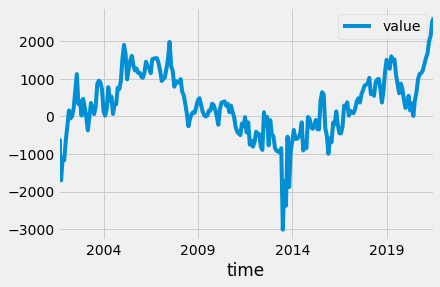

In [12]:
Jacksonville_diff = Jacksonville.diff().dropna()
Jacksonville_diff.plot()
DickeyFullerTest(Jacksonville_diff)

Test Statistic                  -4.525866
p-value                          0.000177
# Lags Used                     14.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64

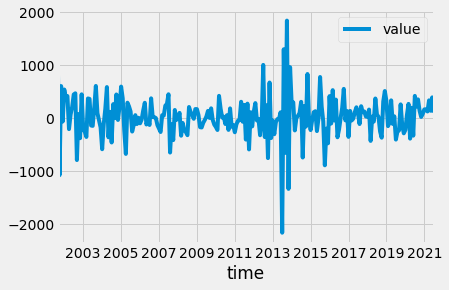

In [13]:
Jacksonville_diff2 = Jacksonville_diff.diff().dropna()
Jacksonville_diff2.plot()
DickeyFullerTest(Jacksonville_diff2)

### ACF and PACF

In [14]:
plot_pacf(Jacksonville_diff3);

NameError: name 'Jacksonville_diff3' is not defined

In [ ]:
plot_acf(Jacksonville_diff3);

### Train Test Split

In [ ]:
cutoff = round(Jacksonville_diff2.shape[0]*.8)
train = Jacksonville_diff2[:cutoff]
test = Jacksonville_diff2[cutoff:]

In [ ]:
train

### Replace outliers greater than 3.5 std. with the median

In [ ]:
def replace_with_median(df, lower_thresh, upper_thresh, median):
    df.loc[df['value'] > upper_thresh] =  median
    df.loc[df['value'] < lower_thresh] = median
    return df

def get_replacement_vals(df):
    std = df['value'].std(ddof=0)
    mean = df['value'].mean()
    median = df['value'].median()
    lower_thresh = (-3.5 * std) + mean
    upper_thresh = (3.5 * std) + mean
    return median, lower_thresh, upper_thresh

def replace_outliers(train, test=pd.DataFrame()):
    train_copy = train.copy()
    median, lower_thresh, upper_thresh = get_replacement_vals(train_copy)
    stand_train = replace_with_median(train_copy, lower_thresh, upper_thresh, median)
    if not test.empty:
        test_copy = test.copy()
        stand_test = replace_with_median(test_copy, lower_thresh, upper_thresh, median)
        return stand_train, stand_test
  
    return stand_train


In [ ]:
stand_train, stand_test = replace_outliers(train=train, test=test)

In [ ]:
stand_test.plot(figsize=(12,8));

In [ ]:
stand_train.plot(figsize=(12,8));

### Naive Model

In [ ]:
naive_model(train, test)

## Arima Model

### Random Walk Model

In [ ]:
random_walk_model = ARIMA(train, order=(0,1,0)).fit()
y_hat = random_walk_model.predict(type='levels')
RMSE = np.sqrt(mean_squared_error(train[1:], y_hat[1:]))
RMSE

### Auto ARIMA

In [ ]:
auto_Jacksonville = pm.auto_arima(train, 
                                  start_p=0,
                                  start_q=0,
                                  max_p=10,
                                  max_q=10,
                                  d=None,
                                  seasonal=True,
                                  start_P=0,
                                  start_Q=0,
                                  max_P=10,
                                  max_Q=10,
                                  m=12,
                                  D=None,
                                  test='kpss',
                                  trace=True,
                                  stepwise=True,
                                  n_fits=1000)

In [ ]:
sarimax_model = SARIMAX(train, order=(3,2,0), seasonal_order=(2,0,0,12),
                       enforce_stationarity=False, enforce_invertability=False).fit()
yhat_train = sarimax_model.predict(type='levels')
RMSE = np.sqrt(mean_squared_error(train[4:], yhat_train[4:]))
RMSE

In [ ]:
yhat_train

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(train[4:], label='Original Train')
ax.plot(yhat_train[4:], label='Train Predictions')
ax.legend();

### SARIMAX GridSearch and Model

In [ ]:
#def sarimax_search(train, p=range(1,3), d=range(1,2), q=range(1,3), maxiter=50,
#                   enforce_stationarity=False, enforce_invertibility=False):
#    
#    """
#    Takes in training data and p, q, d, and returns SARIMAX models with RMSE.  After all iterations,
#    prints the best model and RMSE.
#    
#    Parameters
#    ----------
#    train = training data
#    p: (range) for the iterations of p in SARIMAX model, default = range(1,3)
#    d: (range) for the iterations of d in SARIMAX model, default = range(1,2)
#    q: (range) for the iterations of q in SARIMAX model, default = range(1,3)
#    maxiter: maximum interations, default=50
#    enforce_stationarity:  default = False
#    enforce_invertibility: default = False
#    """
#    
#    pdq = list(itertools.product(p, d, q))
#    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
#    
#    count = 0
#    for param in pdq:
#        for seasonal_param in seasonal_pdq:
#            count += 1
#    print(f'THERE ARE {count} ITERATIONS')
#    answer = input("Would you like to run the models? (y or n)?")
#    
#    if (answer == 'y' or answer == 'yes'):
#        lowest_aic = 1e10
#        for param in pdq: 
#            for seasonal_param in seasonal_pdq:
#                try: 
#                    model = SARIMAX(train, order=param, seasonal_order=seasonal_param,
#                                   enforce_stationarity=enforce_stationarity, 
#                                    enforce_invertibility=enforce_invertibility)
#                    results = model.fit(maxiter=maxiter)
#                    print(f'SARIMAX {param} x {seasonal_param} - AIC:{results.aic}')
#                    if results.aic < lowest_aic:
#                        lowest_aic = results.aic
#                        best_param = param
#                        best_seasonal_param = seasonal_param
#                except:
#                    print('Oops!')
#                    continue
#        print(f'BEST RESULTS:  SARIMAX {best_param} x {best_seasonal_param} - AIC:{results.aic}')  
#    else:
#        print('OK, SARIMAX models will not be run.')

In [ ]:
sarimax_search(train, p=range(2,3), d=range(0,3), q=range(0,2), maxiter=50)

In [ ]:
sarimax_model2 = SARIMAX(train, order=(2,2,0), seasonal_order=(2,2,1,12),
                       enforce_stationarity=False, enforce_invertability=False).fit(maxiter=50)
yhat_train = sarimax_model2.predict(type='levels')
RMSE = np.sqrt(mean_squared_error(train[1:], yhat_train[1:]))
RMSE

In [ ]:
yhat_train

### Facebook Prophet Model

In [ ]:
Jacksonville_proph = Jacksonville.reset_index()
Jacksonville_proph = Jacksonville_proph.rename(columns={'time':'ds', 'value':'y'})

In [ ]:
fbprophet_func(Jacksonville_proph, city='Jacksonville, NC')

### LSTM Model

In [ ]:
history = LSTM_func(Jacksonville_proph, City=Jacksonville, epochs=100)

In [ ]:
LSTM_val(history)

## Best Model

In [ ]:
final_model = proph(interval_width=.95)
final_model.fit(Jacksonville_proph)
future_dates = final_model.make_future_dataframe(periods=60, freq='MS')
forecast = final_model.predict(future_dates)
final_model.plot(forecast, uncertainty=True);

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(Jacksonville_proph.ds, Jacksonville_proph.y, label='Actual')
ax.plot(forecast.ds, forecast.yhat, label='Forecasted')
ax.set_title('Forecasted vs. Acutual Home Prices in 28546 (Jacksonville, NC)')
ax.set_ylabel('Dollars')
ax.legend();

In [ ]:
current_price = int(Jacksonville_proph[Jacksonville_proph.ds == '2021-07-01'].y.values)
predicted_price = int(forecast[forecast.ds == '2026-07-01'].yhat.values)
pred_five_year_increase = predicted_price - current_price
five_year_roi = pred_five_year_increase / current_price
print(f'Current price:                ${current_price}')
print(f'Predicted 2026 price:         ${predicted_price}')
print(f'Predicted five year increase: ${pred_five_year_increase}')
print(f'Predicted five year ROI:      {five_year_roi}')